# Combining paired C3 and C4 runs 

This section describes a methods to combine TSS-RESTREND attribution runs done assuming a C3 and a C4 photosyenthetic pathway. The TSSRattribution function in Version 0.3.1 of the TSS.RESTREND has the optional argument C4frac which removes the need for this code. It is kept here for reference purposes only.  


### Build two runs

To build the two matched runs us the following:

```bash
# C3 run
python S00_SetupMetadata.py --coarsen 5  --photo "C3"
python S01_processingnetcdf.py
Rscript S02_TSSRESTRENDattribution.R  --ncores -1
python S03_MappingResults.py -p

# C4 run
python S00_SetupMetadata.py --coarsen 5  --photo "C4" -a
python S01_processingnetcdf.py
Rscript S02_TSSRESTRENDattribution.R  --ncores -1
python S03_MappingResults.py -p

```

After this code is complete, there will be two files in the results folder called "TSSRattribution_Results_C3_125km.nc" and "TSSRattribution_Results_C4_125km.nc".  

In [5]:
import numpy as np
import pandas as pd
import xarray as xr
import bottleneck as bn
from scipy import stats
import matplotlib.pyplot as plt
# import statsmodels.stats.multitest as smsM

Next step is to load in the relevant datasets.  There are three netcdf files: a C3 run, a C4 run and the fraction of C4 photosyenthetic plants.

In [6]:
# The C3 run
ds_c3 = xr.open_dataset("./results/TSSRattribution_Results_C3_125km.nc")
# The C4 run
ds_c4 = xr.open_dataset("./results/TSSRattribution_Results_C3_125km.nc")
# The fraction of C4 plans 
C4frac = xr.open_dataset("./data/AUSdemo_SYNMAP_C4Fraction_xrcoarsen_5win.nc")

# ===== print one of the datasets =====
print(ds_c3)

<xarray.Dataset>
Dimensions:                            (latitude: 28, longitude: 36, time: 1)
Coordinates:
  * longitude                          (longitude) float64 112.5 113.8 ... 155.9
  * latitude                           (latitude) float64 -10.5 ... -44.12
  * time                               (time) datetime64[ns] 2015-12-31
Data variables:
    ObservedChange                     (time, latitude, longitude) float64 ...
    CO2                                (time, latitude, longitude) float64 ...
    LandUse                            (time, latitude, longitude) float64 ...
    ClimateChange                      (time, latitude, longitude) float64 ...
    ClimateVariability                 (time, latitude, longitude) float64 ...
    OtherFactors                       (time, latitude, longitude) float64 ...
    OtherFactorsValid                  (time, latitude, longitude) bool ...
    Obs.Pvalue                         (time, latitude, longitude) float64 ...
    CO2.Pvalue     

The next step is to define a couple of functions. The first function is called Weighted_mean and it will just get the mean of the two runs, weighted by the fraction of C4 plans in each pixel.  The second uses stouffer's method to combine the pvalues for that variable with the C4frac being as weights.   

In [7]:
def Weighted_mean(ds_c3, ds_c4, C4frac, var):
    # pull out the dataarrays
    da_c3 = ds_c3[var]
    da_c4 = ds_c4[var]
    C4f   = C4frac["C4frac"].values

    #Calculate the weighted mean
    c4_adj = (da_c4 * C4f) + (da_c3 * (1-C4f))

    #return the results
    return c4_adj


def Combinee_Pvalues(ds_c3, ds_c4, C4frac, pvar):
    # Pull out the p values
    # Stack long and land to make 1d array
    da_c3p = ds_c3[pvar].stack(cord=('longitude', 'latitude'))
    da_c4p = ds_c4[pvar].stack(cord=('longitude', 'latitude'))
    C4f_p  = C4frac["C4frac"].stack(cord=('longitude', 'latitude'))
    C3f_p  = 1-C4f_p

    # stack into a 2d array so i can use  np.apply_along_axis 
    stacked = np.vstack([da_c3p.values, da_c4p.values, C4f_p.values, C3f_p.values])

    def _combine_2pvalue(array):
        pvals  = array[:2]
        wei    = array[2:]
        if bn.allnan(pvals):
            return np.NaN
        else:
            # Deal with pvalues that are= 0. It happens when the values are smaller than the is possible with float 32.  If they are pased to 
            # stats.combine_pvalues it will return nan
            pvals[pvals==0] = 0.000001
            #Deals with places where thing failed to get a p values
            pvals[np.isnan(pvals)] = 1 

            # Adjust the pvalues
            sta, pv = stats.combine_pvalues(pvals, method="stouffer", weights=wei)
            return np.array(pv)

    # ===== Apply the 2d pvalue combination function to calculate the new pvalues =====
    res = np.apply_along_axis(_combine_2pvalue, 0, stacked).reshape([1,-1])

    # Convert back intoa a datarray 
    pv_adj = da_c3p.copy(data=res)
    # Unstack the lats and lons then return the result
    return pv_adj.unstack().transpose('time', 'latitude', 'longitude').sortby("latitude", ascending=False)

In this example, we will only adjust the CO<sub>2<sub/> results. In practice it would be done to every variable and the associated p-values


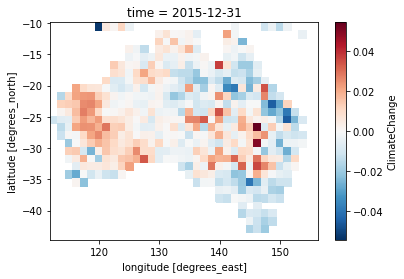

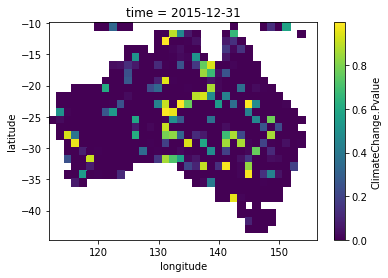

In [8]:
# Set the name of the var and the pvar
var  = "ClimateChange"
pvar = "ClimateChange.Pvalue"
# Calculate tthe adjusted 
VARadj = Weighted_mean(ds_c3, ds_c4, C4frac, var)
VARadj_pvalues = Combinee_Pvalues(ds_c3, ds_c4, C4frac, pvar)
# make some plots
plt.figure(var)
VARadj.plot()
plt.figure(pvar)
VARadj_pvalues.plot()

plt.show()


